In [1]:
import random
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import botorch

from botorch.test_functions import Branin
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.sampling.samplers import IIDNormalSampler

from conformalbo.utils import generate_initial_data, initialize_model, optimize_acqf_and_get_observation
from conformalbo.acquisitions import qConformalUpperConfidenceBound


sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.double

In [2]:
grid_res = 16

x1 = torch.linspace(0, 1, steps=grid_res, device=DEVICE, dtype=dtype)
x2 = torch.linspace(0, 1, steps=grid_res, device=DEVICE, dtype=dtype)
x1, x2 = torch.meshgrid(x1, x2, indexing='xy')
x_grid = torch.stack([x1.reshape(-1), x2.reshape(-1)], dim=-1)

# fig, ax = plt.subplots()
# ax.scatter(x_grid[:, 0].cpu(), x_grid[:, 1].cpu())
# ax.set_xlabel(r'$x_1$')
# ax.set_ylabel(r'$x_2$', rotation=0)
# plt.tight_layout()

In [3]:
bb_fn = Branin(negate=True)
cube_loc = bb_fn.bounds[0].to(x_grid)
cube_scale = (bb_fn.bounds[1] - bb_fn.bounds[0]).to(x_grid)
f_grid = bb_fn(x_grid * cube_scale + cube_loc).view(grid_res, grid_res)

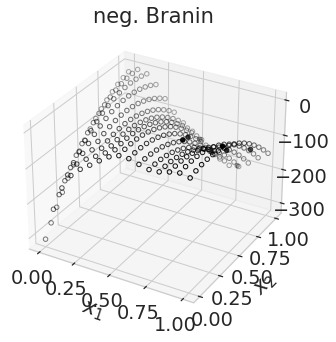

In [4]:
num_init = 8
noise_se = 0.1
mc_samples = 64
num_restarts = 4
q_batch_size = 1
seed = 132
# seed = np.random.randint(0, 1000)
# print(seed)

random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)

train_inputs, train_y, best_f = generate_initial_data(
    num_init, bb_fn, noise_se, DEVICE, dtype, rand_orthant=True
)
train_f = bb_fn(train_inputs * cube_scale + cube_loc).view(-1)

fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection='3d')

ax.scatter(
    train_inputs[:, 0].view(-1).cpu(),
    train_inputs[:, 1].view(-1).cpu(),
    train_f.view(-1).cpu(), color='black'
)
ax.scatter(
    x_grid[:, 0].view(-1).cpu(),
    x_grid[:, 1].view(-1).cpu(),
    f_grid.view(-1).cpu(), edgecolors='black', facecolors='none'
)

ax.set_title('neg. Branin')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$', rotation=0)
plt.tight_layout()

In [5]:
mll, model, trans = initialize_model(
    train_inputs,
    train_y,
    method='exact',
    train_yvar=noise_se**2,
)
model.requires_grad_(True)
botorch.fit_gpytorch_model(mll)
model.requires_grad_(False)

sampler = IIDNormalSampler(mc_samples)

In [6]:
nonconf_acq_fn = qUpperConfidenceBound(
    model=model,
    sampler=sampler,
    beta=1.
)

nonconf_acq_vals = nonconf_acq_fn(x_grid[:, None]).view(grid_res, grid_res)

/home/sam/miniconda3/envs/conf-bo-env/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [7]:
alpha = 1. / math.sqrt(train_inputs.size(0))
# alpha = 1. / (train_inputs.size(0) - 1)
print(f"alpha: {alpha:0.4f}")
conformal_kwargs = dict(
    alpha=alpha,
    temp=0.1,
    grid_res=mc_samples,
    max_grid_refinements=0,
    ratio_estimator=None,
    grid_sampler=IIDNormalSampler(mc_samples)
)
    
conf_acq_fn = qConformalUpperConfidenceBound(
    model=model,
    sampler=sampler,
    beta=1.,
    **conformal_kwargs
)
conf_acq_vals = conf_acq_fn(x_grid[:, None]).view(grid_res, grid_res)

alpha: 0.3536


In [8]:
input_bounds = torch.stack([
    torch.zeros(bb_fn.dim, device=DEVICE, dtype=dtype),
    torch.ones(bb_fn.dim, device=DEVICE, dtype=dtype),
])
optimize_acqf_kwargs = {
    "bounds": input_bounds,
    "BATCH_SIZE": q_batch_size,
    "NUM_RESTARTS": num_restarts,
    "fn": bb_fn,
    "noise_se": noise_se,
}

In [9]:
def draw_plot(ax_titles):
    fig = plt.figure(figsize=(18, 5))

    ax = fig.add_subplot(1, 3, 1)
    ax.set_title(ax_titles[0])
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$', rotation=0)
    cbar = ax.contourf(x1.cpu(), x2.cpu(), -(-f_grid).log().cpu(), cmap='plasma')
    ax.scatter(train_inputs[:, 0].cpu(), train_inputs[:, 1].cpu(), color='black')
    fig.colorbar(cbar)

    ax_2 = fig.add_subplot(1, 3, 2)
    ax_2.set_title(ax_titles[1])
    ax_2.set_xlabel(r'$x_1$')
    ax_2.set_ylabel(r'$x_2$', rotation=0)
    cbar = ax_2.contourf(x1.cpu(), x2.cpu(), nonconf_acq_vals.cpu(), cmap='plasma')
    ax_2.scatter(train_inputs[:, 0].cpu(), train_inputs[:, 1].cpu(), color='black')
#     ax_2.scatter(nonconf_x_traj[:, 0].cpu(), nonconf_x_traj[:, 1].cpu(), color='gray', marker='x')
    ax_2.scatter(nonconf_x_best[:, 0].cpu(), nonconf_x_best[:, 1].cpu(), color='red', marker='x')
    fig.colorbar(cbar)

    ax_3 = fig.add_subplot(1, 3, 3)
    ax_3.set_title(ax_titles[2])
    ax_3.set_xlabel(r'$x_1$')
    ax_3.set_ylabel(r'$x_2$', rotation=0)
    cbar = ax_3.contourf(x1.cpu(), x2.cpu(), conf_acq_vals.cpu(), cmap='plasma')
    ax_3.scatter(train_inputs[:, 0].cpu(), train_inputs[:, 1].cpu(), color='black')
#     ax_3.scatter(conf_x_traj[:, 0].cpu(), conf_x_traj[:, 1].cpu(), color='gray', marker='x')
    ax_3.scatter(conf_x_best[:, 0].cpu(), conf_x_best[:, 1].cpu(), color='red', marker='x', s=32)
    fig.colorbar(cbar)

    plt.tight_layout()

/tmp/ipykernel_4302/1710329769.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)
/tmp/ipykernel_4302/1710329769.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)
/tmp/ipykernel_4302/1710329769.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)


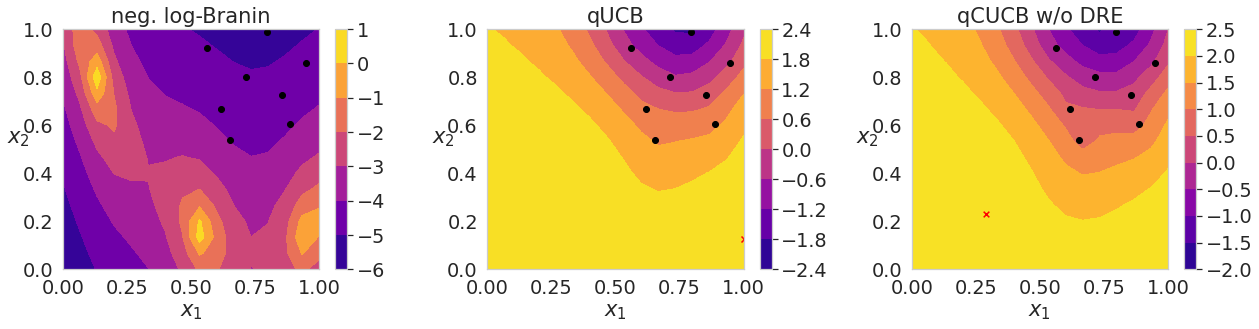

In [10]:
nonconf_result = optimize_acqf_and_get_observation(nonconf_acq_fn, **optimize_acqf_kwargs)
nonconf_x_best = nonconf_result[0].flatten(0, -2)
nonconf_x_traj = nonconf_result[-2].flatten(0, -2)

conf_result = optimize_acqf_and_get_observation(conf_acq_fn, **optimize_acqf_kwargs)
conf_x_best = conf_result[0].flatten(0, -2)
conf_x_traj = conf_result[-2].flatten(0, -2)

ax_titles = ["neg. log-Branin", "qUCB", "qCUCB w/o DRE"]
draw_plot(ax_titles)

DR estimator EMA weight: 0.0156


/tmp/ipykernel_4302/1710329769.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)
/tmp/ipykernel_4302/1710329769.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)
/tmp/ipykernel_4302/1710329769.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)


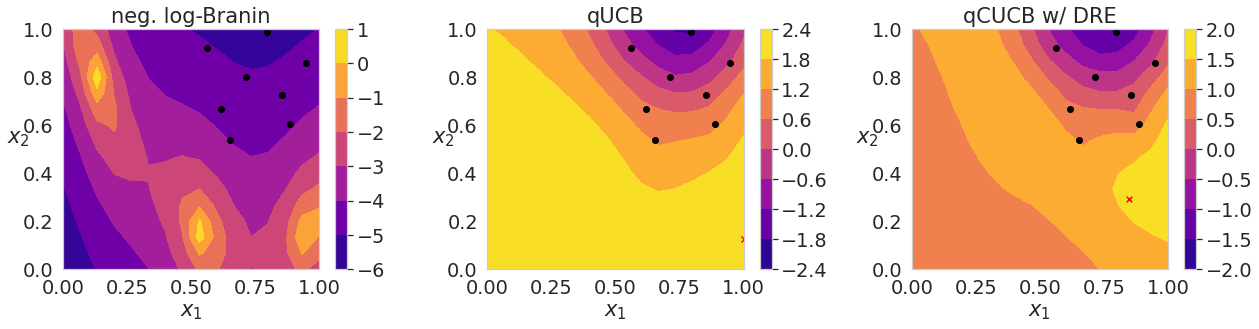

In [11]:
from conformalbo.ratio_estimation import RatioEstimator
from lambo.utils import DataSplit

ema_weight = 2. / 128.
print(f"DR estimator EMA weight: {ema_weight:0.4f}")
rx_estimator = RatioEstimator(train_inputs.size(-1), DEVICE, dtype, ema_weight, lr=1e-3)
rx_estimator.dataset._update_splits(
    DataSplit(train_inputs.cpu(), torch.zeros(train_inputs.size(0), 1))
)
conformal_kwargs['ratio_estimator'] = rx_estimator

conf_acq_fn = qConformalUpperConfidenceBound(
    model=model,
    sampler=sampler,
    beta=1.,
    **conformal_kwargs
)

conf_result = optimize_acqf_and_get_observation(conf_acq_fn, **optimize_acqf_kwargs)
conf_x_best = conf_result[0].flatten(0, -2)
conf_x_traj = conf_result[-2].flatten(0, -2)
conf_acq_vals = conf_acq_fn(x_grid[:, None]).view(grid_res, grid_res)

ax_titles[-1] = "qCUCB w/ DRE"
draw_plot(ax_titles)

In [12]:
dr_grid = conf_acq_fn.ratio_estimator(x_grid)
dr_train = conf_acq_fn.ratio_estimator(train_inputs).expand(dr_grid.size(0), -1)

imp_weights = torch.cat([dr_train, dr_grid[:, None]], dim=-1)
imp_weights /= imp_weights.sum(dim=-1, keepdim=True).clamp_min(1e-6)
imp_weights = imp_weights[:, -1].view(grid_res, grid_res)

/tmp/ipykernel_4302/4148556806.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)
/tmp/ipykernel_4302/4148556806.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)


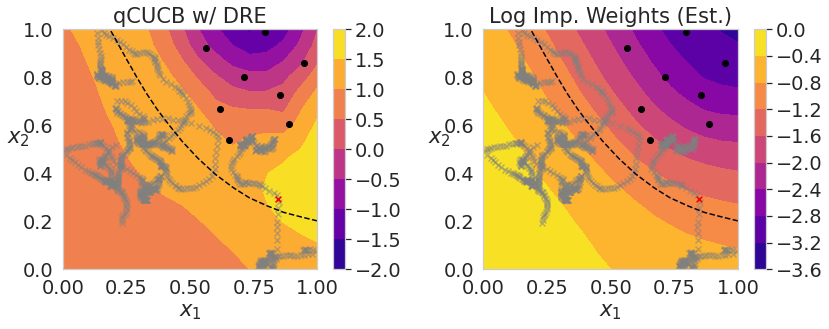

In [13]:
fig = plt.figure(figsize=(12, 5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1.set_title("qCUCB w/ DRE")
ax_1.set_xlabel(r'$x_1$')
ax_1.set_ylabel(r'$x_2$', rotation=0)
ax_1.contour(x1.cpu(), x2.cpu(), imp_weights.log().cpu(), levels=[math.log(alpha)], linestyles=('--',))
# ax_1.contour(x1.cpu(), x2.cpu(), conf_acq_vals.cpu(), levels=[0.], linestyles=('--',), colors=('black',))
cbar = ax_1.contourf(x1.cpu(), x2.cpu(), conf_acq_vals.cpu(), cmap='plasma')
ax_1.scatter(train_inputs[:, 0].cpu(), train_inputs[:, 1].cpu(), color='black')
ax_1.scatter(conf_x_traj[:, 0].cpu(), conf_x_traj[:, 1].cpu(), color='gray', marker='x', alpha=0.5)
ax_1.scatter(conf_x_best[:, 0].cpu(), conf_x_best[:, 1].cpu(), color='red', marker='x', s=32)
fig.colorbar(cbar)

ax_2 = fig.add_subplot(1, 2, 2)
ax_2.set_title("Log Imp. Weights (Est.)")
ax_2.set_xlabel(r'$x_1$')
ax_2.set_ylabel(r'$x_2$', rotation=0)
ax_2.contour(x1.cpu(), x2.cpu(), imp_weights.log().cpu(), levels=[math.log(alpha)], linestyles=('--',))
cbar = ax_2.contourf(x1.cpu(), x2.cpu(), imp_weights.log().cpu(), cmap='plasma')
ax_2.scatter(train_inputs[:, 0].cpu(), train_inputs[:, 1].cpu(), color='black')
ax_2.scatter(conf_x_traj[:, 0].cpu(), conf_x_traj[:, 1].cpu(), color='gray', marker='x', alpha=0.5)
ax_2.scatter(conf_x_best[:, 0].cpu(), conf_x_best[:, 1].cpu(), color='red', marker='x', s=32)
fig.colorbar(cbar)

plt.tight_layout()